In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import plotly.graph_objs as go
import math
from typing import Callable, Tuple, Dict, Union

In [2]:
def get_qq_plot(p_values):
    """Рисует распределение p-value"""
    p_values = np.array(p_values)
    probs = []
    x = [0.01 * i for i in range(101)]
    for i in range(101):
        alpha_step = 0.01 * i
        probs.append(p_values[p_values < alpha_step].shape[0] / p_values.shape[0])
    fig = go.Figure([go.Scatter(x=x, y=probs, mode="markers", name="p_value"),
                 go.Scatter(x=x, y=x, mode="lines", name="uniform")])
    fig.update_layout(height=600, width=600, title="Q-Q plot")
    fig.show('png')
    # return fig

In [3]:
def get_power(p_values, alpha=0.05):
    """Оценка мощности критерия, при условии, что значения p_value взяты при наличии 
    различий в сравниваемых выборках 
    """
    p_values = np.array(p_values)
    return p_values[p_values < alpha].shape[0] / p_values.shape[0] * 100

In [4]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.1):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

def duration_int(k: int,
                 delta_effect: float,
                 sigma_1: float,
                 sigma_2: float,
                 alpha: float = 0.05,
                 beta: float = 0.1) -> int:
    test_duration = duration(k, delta_effect, sigma_1, sigma_2, alpha, beta)
    return math.ceil(test_duration)

def get_sigma(p: float) -> float:
    return np.sqrt(p * (1 - p))


### 1. Реализация формулы подсчета длительности теста

In [32]:
# for normal distribution
def calculate_test_duration_and_power(k: int = 2,
                                      n_samples: int = 1000,
                                      alpha: float = 0.05,
                                      beta: float = 0.2,
                                      p: float = 0.05,                                  
                                      delta_effect: float = 0.01) -> Dict[str, Union[int, float]]:
    
    duration = duration_int(k=k,
                            delta_effect=delta_effect,
                            sigma_1=get_sigma(p),
                            sigma_2=get_sigma(p + delta_effect),
                            alpha=alpha,
                            beta=beta)

    p_values = []
    for _ in range(n_samples):
        x_a = sps.norm.rvs(loc=0, scale=get_sigma(p), size=duration)
        x_b = sps.norm.rvs(loc=delta_effect, scale=get_sigma(p), size=duration)
        
        p_value = sps.ttest_ind(x_a, x_b, equal_var=False).pvalue
        p_values.append(p_value)
    
    criterion_power = get_power(p_values, alpha)

    return {"duration" : duration, "power" : criterion_power}

![mindbox size calculation №1](images/mindbox_1.png)

In [33]:
result = calculate_test_duration_and_power(k = 1,
                                           n_samples = 1000,
                                           alpha = 0.05,
                                           beta = 0.2,
                                           p = 0.2,
                                           delta_effect = 0.07)

print(f'duration: {result["duration"]}\npower: {result["power"]}%')

duration: 1145
power: 99.1%


![mindbox size calculation №2](images/mindbox_2.png)

In [34]:
result = calculate_test_duration_and_power(k = 1,
                                           n_samples = 1000,
                                           alpha = 0.03,
                                           beta = 0.1,
                                           p = 0.1,
                                           delta_effect = 0.01)

print(f'duration: {result["duration"]}\npower: {result["power"]}%')

duration: 44773
power: 100.0%


__Note:__ Как мы видим, есть отклонение от итогового результата ("всего"), но сравнительно небольшое. Я думаю, это может быть связано с формулой подсчета продолжительности теста

### 2. Имплементация метода линеаризации

In [191]:
def linearization(n_exp: int = 1000,
                  p: float = 0.05,
                  effect: float = 0) -> Tuple[np.ndarray, np.ndarray]:
    p_values = []
    p_values_lin = []
    
    mu, sigma = 100, 100
    n_iter = 100

    for _ in range(n_exp):
        records = []
        for i in range(n_iter):
            n_views = int(sps.expon.rvs(loc=mu, scale=sigma))
            clicks = sps.bernoulli.rvs(p=p, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "A"])
        for i in range(n_iter):
            n_views = int(sps.expon.rvs(loc=mu, scale=sigma))
            clicks = sps.bernoulli.rvs(p=p+effect, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "B"])
        df_data = pd.DataFrame(records, columns=["views", "clicks", "cr", "group"])
        
        cr_A = df_data[df_data["group"] == "A"]["clicks"].sum() / df_data[df_data["group"] == "A"]["views"].sum()
        df_data["cr_lin"] = df_data["clicks"] - cr_A * df_data["views"]

        x_a = df_data[df_data["group"] == "A"]["cr"]
        x_b = df_data[df_data["group"] == "B"]["cr"]
        p_value = sps.ttest_ind(x_a, x_b).pvalue
        p_values.append(p_value)
        
        x_a_lin = df_data[df_data["group"] == "A"]["cr_lin"]
        x_b_lin = df_data[df_data["group"] == "B"]["cr_lin"]
        p_value_lin = sps.ttest_ind(x_a_lin, x_b_lin).pvalue
        p_values_lin.append(p_value_lin)

    p_values = np.array(p_values)
    p_values_lin = np.array(p_values_lin)
    
    return p_values, p_values_lin

In [192]:
p_values, p_values_lin = linearization(n_exp=1000, p=0.05)

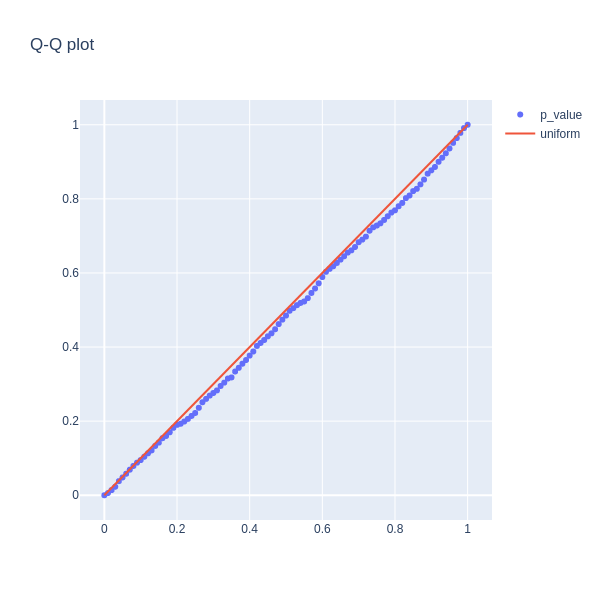

In [193]:
# Without linearization
get_qq_plot(p_values)

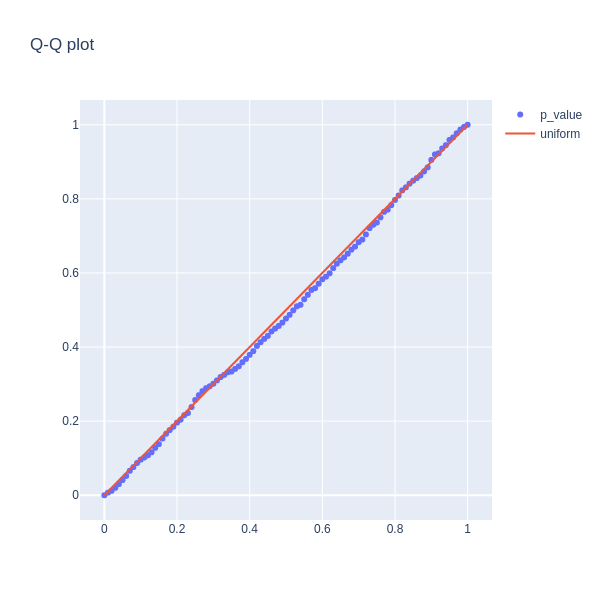

In [194]:
# With Lizearization
get_qq_plot(p_values_lin)

__Note:__ Из графиков можно увидеть, что критерий корректен

__Note:__ Возьмем небольшой эффект и проверим, что мощность после линеаризации увеличится.

In [195]:
p_values, p_values_lin = linearization(p=0.05, effect=0.005)

In [196]:
power = get_power(p_values)
power_lin = get_power(p_values_lin)

In [198]:
assert power_lin > power

print(f'Power without linearization: {power:.2f}')
print(f'Power with linearization: {power_lin:.2f}')

Power without linearization: 54.00
Power with linearization: 59.90


### 3. Имплементация метода CUPED

In [283]:
def cuped(n_exp: int = 1000,
          size: int = 1000,
          mu_pre: int = 100,
          sigma_pre: int = 20,
          mu: int = 100,
          sigma: int = 100,
          effect: int = 10) -> Tuple[np.ndarray, np.ndarray]:
        
    p_values = []
    p_values_cuped = []

    # Pre_experiment
    pre_exp = sps.norm.rvs(loc=mu_pre, scale=sigma_pre, size=size)
    for _ in range(n_exp):
        
        df_A = pd.DataFrame()
        df_A["user"] = [f"A_{x:5}" for x in range(size)]
        df_A["pre_exp"] = pre_exp

        df_A["payments"] = sps.norm.rvs(loc=mu, scale=sigma, size=size) * df_A["pre_exp"]

        df_B = pd.DataFrame()
        df_B["pre_exp"] = pre_exp
        df_B["user"] = [f"B_{x:5}" for x in range(size)]
        
        df_B["payments"] = sps.norm.rvs(loc=mu+effect, scale=sigma, size=size) * df_B["pre_exp"]

        p_values.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)
        
        x_a = df_A["pre_exp"]
        x_b = df_B["pre_exp"]
        y_a = df_A["payments"]
        y_b = df_B["payments"]
        theta = np.cov(x_a, y_a)[0,1] / np.std(x_a)**2
        
        df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"]
        df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]
        
        p_values_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)
    
    p_values = np.array(p_values)
    p_values_cuped = np.array(p_values_cuped)

    return p_values, p_values_cuped

In [292]:
p_values, p_values_cuped = cuped(n_exp=1000, size=1000, effect=0)

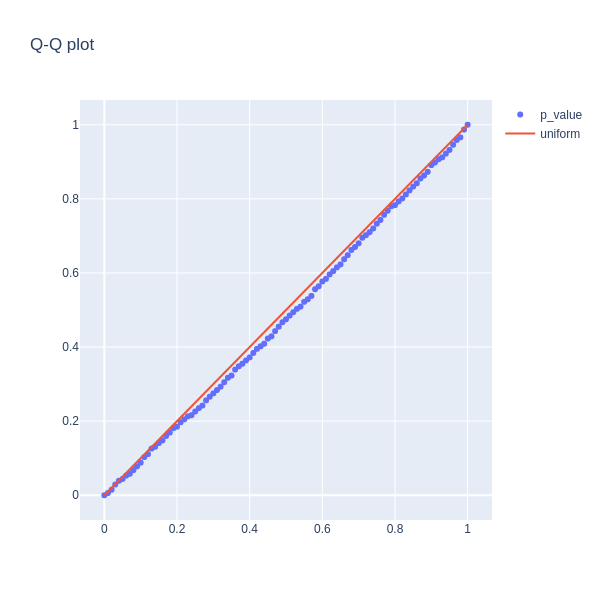

In [293]:
# Standart
get_qq_plot(p_values)

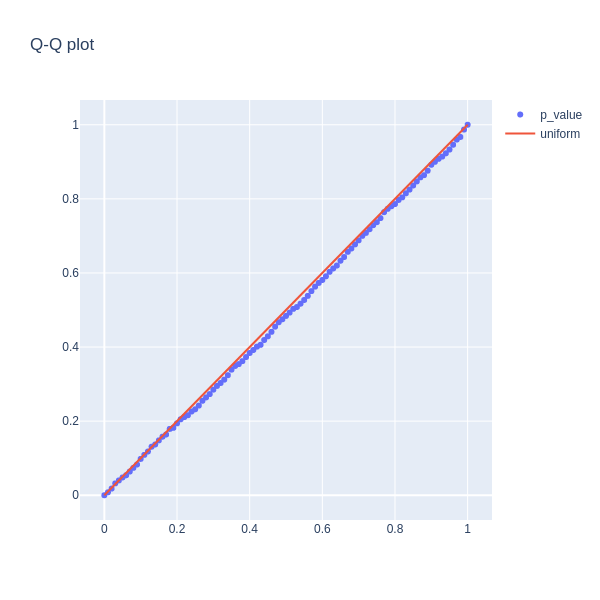

In [294]:
# CUPED
get_qq_plot(p_values_cuped)

__Note:__ Из графиков можно увидеть, что критерий корректен

In [296]:
p_values, p_values_cuped = cuped(n_exp=1000, size=1000,
                                 mu_pre=100, sigma_pre=20,
                                 mu=1, sigma=0.1, effect=0.01)

In [297]:
power = get_power(p_values, alpha=0.05)
power_cuped = get_power(p_values_cuped, alpha=0.05)

assert power_cuped > power

print(f'Power: {power:.2f}')
print(f'Power-cuped: {power_cuped:.2f}')

Power: 2.00
Power-cuped: 58.90


__Note:__ Как мы видим, если корреляции есть, то результат различается довольно сильно (мощность cuped метода заметно больше)